In [1]:
import pandas as pd
import numpy as np
import os
import re
from collections import defaultdict

In [2]:
os.listdir(os.getcwd())

['.ipynb_checkpoints',
 'Call_function_manually_construc.pdf',
 'Call_function_manually_construc.png',
 'Call_function_manually_construc_500.pdf',
 'Call_function_organic.pdf',
 'Call_function_organic.png',
 'Datastatistic.csv',
 'function.json',
 'function_stats_comparison_qemu_fema.pdf',
 'function_stats_ProjectKB.pdf',
 'optimized_call_graph.pdf',
 'optimized_call_graph.png',
 'ProjectKB_domain_csv',
 'QemuFFmpegData.csv',
 'sampleqemuffmpeg.csv',
 'study of the data fron RQ1.ipynb',
 'Withcalllistqemuffmpeg.csv']

In [17]:
dpath = f"{os.getcwd()}/function.json"
print(dpath)

C:\Users\cholo\OneDrive\Desktop\Modeling F GNN\Dataset/function.json


In [18]:
df = pd.read_json(dpath)
df['id'] = df.index
df.head(3)

,project,commit_id,target,func,id
0,FFmpeg,973b1a6b9070e2bf17d17568cbaf4043ce931f51,0,static av_cold int vdadec_init(AVCodecContext ...,0
1,FFmpeg,321b2a9ded0468670b7678b7c098886930ae16b2,0,static int transcode(AVFormatContext **output_...,1
2,FFmpeg,5d5de3eba4c7890c2e8077f5b4ae569671d11cf8,0,"static void v4l2_free_buffer(void *opaque, uin...",2


In [8]:
# df = df[:1000]
# dfffff = df
df.to_csv(f"{os.getcwd()}/sampleqemuffmpeg.csv", index = False)
df['vul'] = df['target']
print(df.columns)
print(set(df['project']))

Index(['project', 'commit_id', 'target', 'func', 'id', 'vul'], dtype='object')
{'qemu', 'FFmpeg'}


In [9]:
assert all(col in df.columns for col in ["project", "func", "vul"]), \
    "Missing one of the required columns: 'project', 'func', 'vul'"

def extract_function_name(code):
    match = re.search(r'\b([a-zA-Z_][\w]*)\s*\([^;]*\)\s*\{', code)
    return match.group(1) if match else None

project_func_map = defaultdict(dict)

for idx, row in df.iterrows():
    project = row["project"]
    code = row["func"]  
    label = row["vul"]
    func_name = extract_function_name(code)

    if func_name:
        project_func_map[project][func_name] = {
            "code": code,
            "vul": label
        }

stats = []

for project, func_dict in project_func_map.items():
    vulnerable_funcs = {f for f, d in func_dict.items() if d["vul"] == 1}
    non_vulnerable_funcs = {f for f, d in func_dict.items() if d["vul"] == 0}

    vul_called_by_non_vul = set()
    total_calls_from_non_vul_to_vul = 0

    for caller_func, caller_data in func_dict.items():
        if caller_data["vul"] != 0:
            continue  

        code = caller_data["code"]
        for callee_func in vulnerable_funcs:
            if re.search(r'\b' + re.escape(callee_func) + r'\s*\(', code):
                vul_called_by_non_vul.add(callee_func)
                total_calls_from_non_vul_to_vul += 1

    stats.append({
        "project": project,
        "total_funcs": len(func_dict),
        "vulnerable_funcs": len(vulnerable_funcs),
        "non_vulnerable_funcs": len(non_vulnerable_funcs),
        "vul_funcs_called_by_non_vul": len(vul_called_by_non_vul),
        "total_non_vul_to_vul_calls": total_calls_from_non_vul_to_vul,
        "vul_func_names_misused": list(vul_called_by_non_vul)
    })

stats_df = pd.DataFrame(stats)

print(stats_df.to_string(index=False))


project  total_funcs  vulnerable_funcs  non_vulnerable_funcs  vul_funcs_called_by_non_vul  total_non_vul_to_vul_calls                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

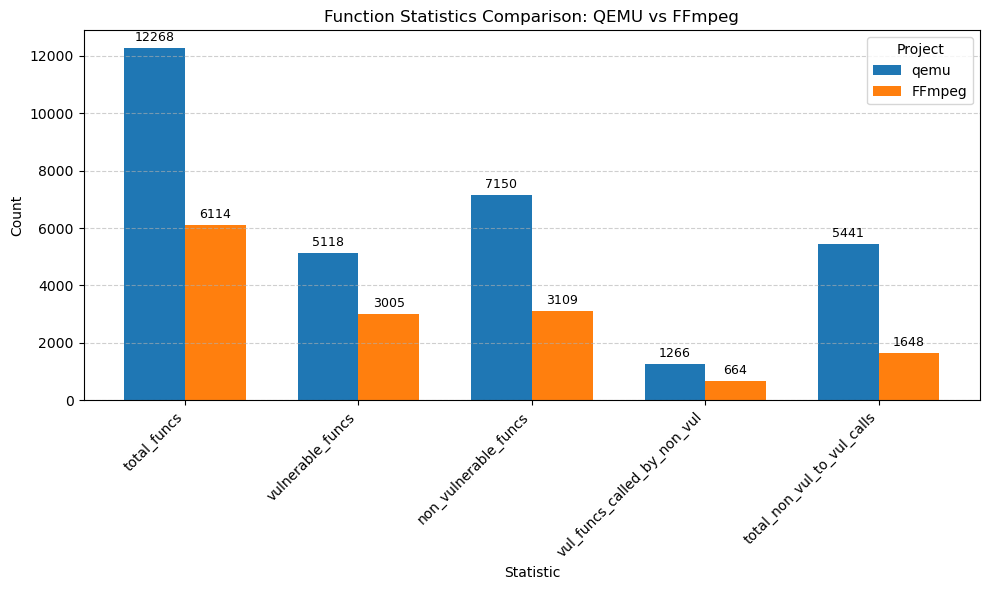

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

projects_of_interest = ["qemu", "FFmpeg"]
filtered_df = stats_df[stats_df["project"].isin(projects_of_interest)]

filtered_df = filtered_df.set_index("project").loc[projects_of_interest]

columns_to_plot = [
    "total_funcs",
    "vulnerable_funcs",
    "non_vulnerable_funcs",
    "vul_funcs_called_by_non_vul",
    "total_non_vul_to_vul_calls"
]

data_to_plot = filtered_df[columns_to_plot].T
bar_width = 0.35
x = np.arange(len(data_to_plot.index))  

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - bar_width / 2, data_to_plot["qemu"], width=bar_width, label="qemu")
bars2 = ax.bar(x + bar_width / 2, data_to_plot["FFmpeg"], width=bar_width, label="FFmpeg")

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)


ax.set_title("Function Statistics Comparison: QEMU vs FFmpeg")
ax.set_ylabel("Count")
ax.set_xlabel("Statistic")
ax.set_xticks(x)
ax.set_xticklabels(data_to_plot.index, rotation=45, ha='right')
ax.legend(title="Project")
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()


plt.savefig("function_stats_comparison_qemu_fema.pdf", format="pdf")

plt.show()


In [11]:
stats_df.to_csv(f"{os.getcwd()}/Datastatistic.csv", index = False)
df.to_csv(f"{os.getcwd()}/QemuFFmpegData.csv", index = False)

In [13]:
stdf = pd.read_csv(f"{os.getcwd()}/Datastatistic.csv")
stdf.head(2)

,project,total_funcs,vulnerable_funcs,non_vulnerable_funcs,vul_funcs_called_by_non_vul,total_non_vul_to_vul_calls,vul_func_names_misused
0,FFmpeg,6114,3005,3109,664,1648,"['av_frame_unref', 'parse_pixel_format', 'find..."
1,qemu,12268,5118,7150,1266,5441,"['object_property_add_str', 'ram_block_add', '..."


In [14]:
dfkb = pd.read_csv(f"{os.getcwd()}/ProjectKB_domain_csv/ProjectKB_domain_csv.csv")
dfkb.head(2)

,id,commit_ID,CVE-ID,CWE-ID,project,func_before,func_after,diff_lines,vul,Domain_decsriptions,Description_Mitre,P Language,Sample Code,Link-sample
0,1,cee45bc9aa0296b35170cb10b5132491c5dbdc88,CVE-2016-5641,nvd,ProjectKB,public class main {\npublic PythonClientCodege...,public class main {\npublic PythonClientCodege...,NaN,0,NaN,NaN,Java,NaN,NaN
1,2,cee45bc9aa0296b35170cb10b5132491c5dbdc88,CVE-2016-5641,nvd,ProjectKB,public class main {\npublic void processOpts()...,public class main {\npublic void processOpts()...,NaN,0,NaN,NaN,Java,NaN,NaN


In [15]:
dfkb['func'] = dfkb['func_before']


df = dfkb


assert all(col in df.columns for col in ["project", "func", "vul"]), \
    "Missing one of the required columns: 'project', 'func', 'vul'"

def extract_function_name(code):
    match = re.search(r'\b([a-zA-Z_][\w]*)\s*\([^;]*\)\s*\{', code)
    return match.group(1) if match else None

# Build project-wise function mapping
project_func_map = defaultdict(dict)

for idx, row in df.iterrows():
    project = row["project"]
    code = row["func"]  
    label = row["vul"]
    func_name = extract_function_name(code)

    if func_name:
        project_func_map[project][func_name] = {
            "code": code,
            "vul": label
        }

stats = []

for project, func_dict in project_func_map.items():
    vulnerable_funcs = {f for f, d in func_dict.items() if d["vul"] == 1}
    non_vulnerable_funcs = {f for f, d in func_dict.items() if d["vul"] == 0}

    vul_called_by_non_vul = set()
    total_calls_from_non_vul_to_vul = 0

    for caller_func, caller_data in func_dict.items():
        if caller_data["vul"] != 0:
            continue  

        code = caller_data["code"]
        for callee_func in vulnerable_funcs:
            if re.search(r'\b' + re.escape(callee_func) + r'\s*\(', code):
                vul_called_by_non_vul.add(callee_func)
                total_calls_from_non_vul_to_vul += 1

    stats.append({
        "project": project,
        "total_funcs": len(func_dict),
        "vulnerable_funcs": len(vulnerable_funcs),
        "non_vulnerable_funcs": len(non_vulnerable_funcs),
        "vul_funcs_called_by_non_vul": len(vul_called_by_non_vul),
        "total_non_vul_to_vul_calls": total_calls_from_non_vul_to_vul,
        "vul_func_names_misused": list(vul_called_by_non_vul)
    })

stats_df = pd.DataFrame(stats)
print("ProjectKB")
print(stats_df.to_string(index=False))


ProjectKB
  project  total_funcs  vulnerable_funcs  non_vulnerable_funcs  vul_funcs_called_by_non_vul  total_non_vul_to_vul_calls                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

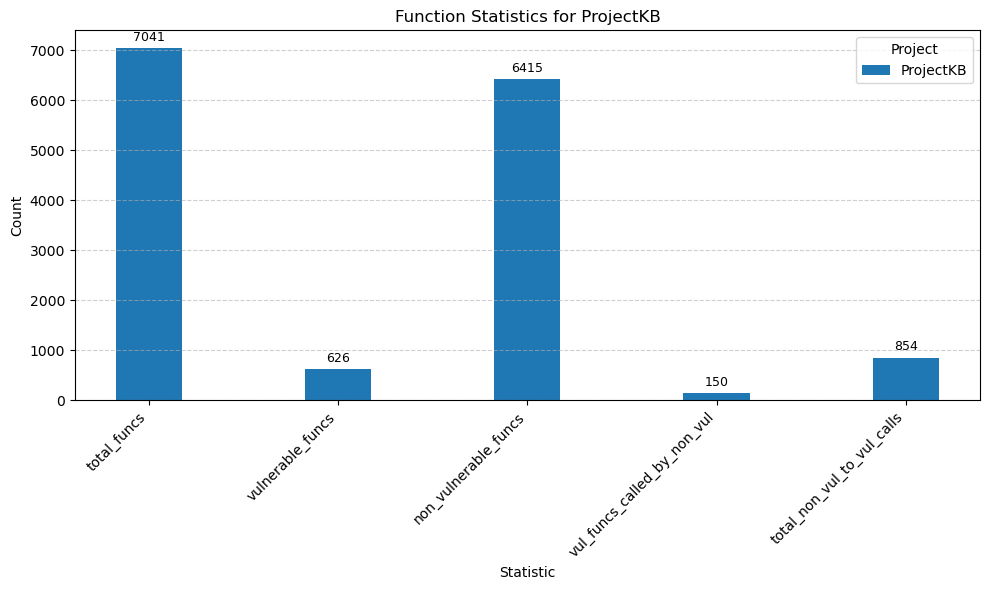

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

projects_of_interest = ["ProjectKB"]
filtered_df = stats_df[stats_df["project"].isin(projects_of_interest)]

filtered_df = filtered_df.set_index("project").loc[projects_of_interest]

columns_to_plot = [
    "total_funcs",
    "vulnerable_funcs",
    "non_vulnerable_funcs",
    "vul_funcs_called_by_non_vul",
    "total_non_vul_to_vul_calls"
]

data_to_plot = filtered_df[columns_to_plot].T
bar_width = 0.35
x = np.arange(len(data_to_plot.index))  

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x, data_to_plot["ProjectKB"], width=bar_width, label="ProjectKB")

for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

ax.set_title("Function Statistics for ProjectKB")
ax.set_ylabel("Count")
ax.set_xlabel("Statistic")
ax.set_xticks(x)
ax.set_xticklabels(data_to_plot.index, rotation=45, ha='right')
ax.legend(title="Project")
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()

plt.savefig("function_stats_ProjectKB.pdf", format="pdf")

plt.show()

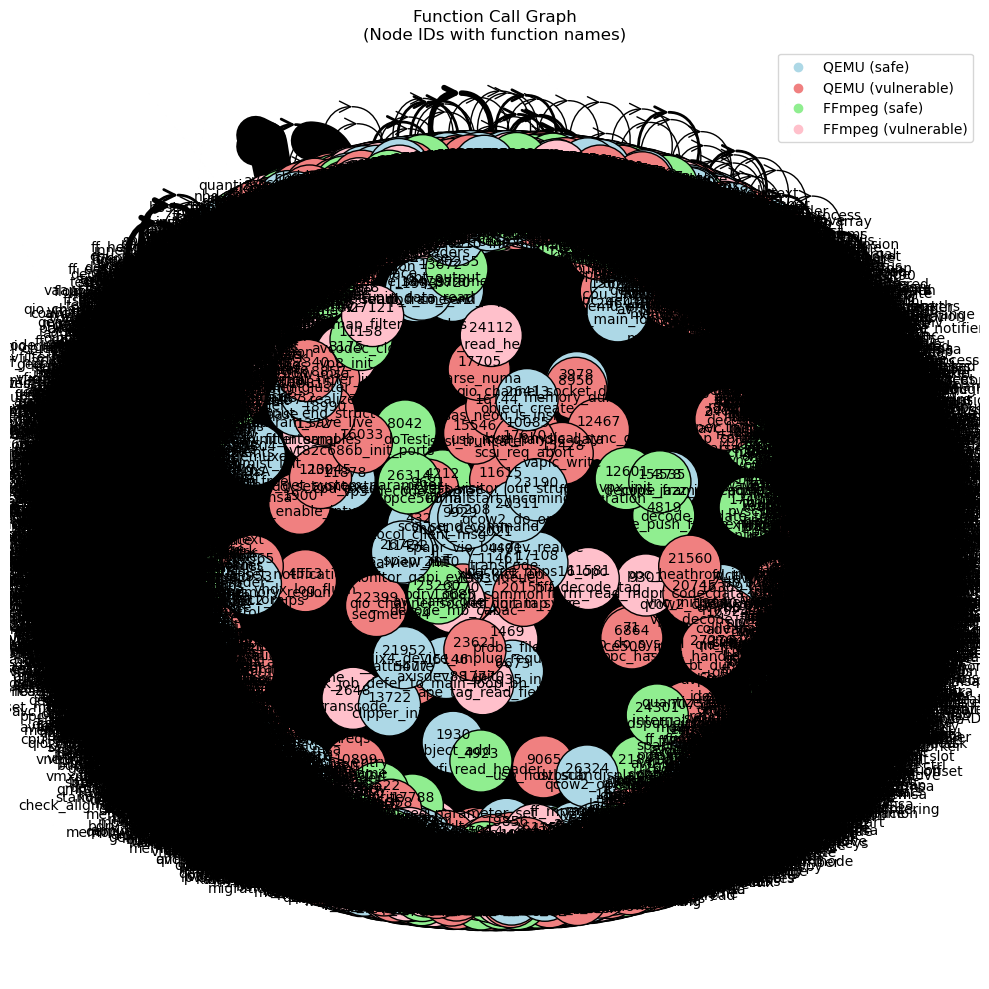

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
from collections import defaultdict


df 
df['vul'] = df['target']


def extract_function_name(code):
    pattern = r'(?:static\s+)?(?:\w+\s+)*(\w+)\s*\([^)]*\)'
    match = re.search(pattern, code.split('{')[0])  # Look before first {
    return match.group(1) if match else None

def extract_function_calls(code, all_functions):
    # Skip the signature part (everything before first {)
    body_start = code.find('{')
    if body_start == -1:
        return []
    code_body = code[body_start:]
    
    
    pattern = r'\b([a-zA-Z_][a-zA-Z0-9_]*)\s*\('
    calls = re.findall(pattern, code_body)
    
    
    return [call for call in calls if call in all_functions 
            and call not in ['if', 'for', 'while', 'switch', 'return']]


def process_function_calls(df):
    df['func_name'] = df['func'].apply(extract_function_name)
    df = df.dropna(subset=['func_name'])  

    all_functions = set(df['func_name'])
    
    df['calls'] = df.apply(
        lambda row: extract_function_calls(row['func'], all_functions),
        axis=1
    )
    
    return df

def adjust_text_labels(text_items, pos, ax):
    """Adjust label positions to minimize overlaps"""
    for key, text in text_items.items():
        x, y = pos[key]
        text.set_position((x, y))
        text.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5))

# # # Visualization function
def visualize_call_graph(df):
    G = nx.DiGraph()
    
    # Create mapping between function names and IDs
    func_to_id = dict(zip(df['func_name'], df['id']))
    
    # Add nodes with attributes
    for _, row in df.iterrows():
        G.add_node(row['id'],
                  label=row['func_name'],
                  project=row['project'],
                  vulnerable=bool(row['vul']))
    
    # Add edges based on calls
    call_counts = defaultdict(int)
    for _, row in df.iterrows():
        caller_id = row['id']
        for callee in row['calls']:
            if callee in func_to_id:
                callee_id = func_to_id[callee]
                G.add_edge(caller_id, callee_id)
                call_counts[(caller_id, callee_id)] += 1
    
    # Visualization
    plt.figure(figsize=(10, 10))

    node_colors = []
    for node in G.nodes():
        attrs = G.nodes[node]
        if attrs['project'] == 'qemu':
            node_colors.append('lightblue' if attrs['vulnerable'] else 'lightcoral')
        else:
            node_colors.append('pink' if attrs['vulnerable'] else 'lightgreen')
    
    labels = {node: f"{node}\n{G.nodes[node]['label']}" for node in G.nodes()}
    
    pos = nx.spring_layout(G, k=0.8, iterations=50)
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=node_colors, 
                         edgecolors='black', linewidths=1)
    

    edge_widths = [call_counts.get((u, v), 1) for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=edge_widths, arrowstyle='->', arrowsize=20)
    
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)
    
    # Legend
    plt.scatter([], [], c='lightblue', label='QEMU (safe)')
    plt.scatter([], [], c='lightcoral', label='QEMU (vulnerable)')
    plt.scatter([], [], c='lightgreen', label='FFmpeg (safe)')
    plt.scatter([], [], c='pink', label='FFmpeg (vulnerable)')
    plt.legend(loc='best')
    
    plt.title("Function Call Graph\n(Node IDs with function names)")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("Call_function_manually_construc.pdf", format="pdf", bbox_inches='tight')
    plt.savefig("Call_function_manually_construc.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()
    
    
    return G

# def visualize_call_graph(df):
#     G = nx.DiGraph()
    
    
#     func_to_id = dict(zip(df['func_name'], df['id']))
    
#     for _, row in df.iterrows():
#         G.add_node(row['id'],
#                   label=row['func_name'],
#                   project=row['project'],
#                   vulnerable=bool(row['vul']))
    
#     call_counts = defaultdict(int)
#     for _, row in df.iterrows():
#         caller_id = row['id']
#         for callee in row['calls']:
#             if callee in func_to_id:
#                 callee_id = func_to_id[callee]
#                 G.add_edge(caller_id, callee_id)
#                 call_counts[(caller_id, callee_id)] += 1

#     connected_nodes = set()
#     for u, v in G.edges():
#         connected_nodes.add(u)
#         connected_nodes.add(v)
    
#     labels = {}
#     for node in G.nodes():
#         if node in connected_nodes:
#             labels[node] = G.nodes[node]['label']  
#         else:
#             labels[node] = str(node) 

    
#     fig = plt.figure(figsize=(9, 9))
#     ax = plt.gca()
    
  
#     node_colors = []
#     for node in G.nodes():
#         attrs = G.nodes[node]
#         if attrs['project'] == 'qemu':
#             node_colors.append('#4e79a7' if attrs['vulnerable'] else '#a0cbe8')
#         else:
#             node_colors.append('#e15759' if attrs['vulnerable'] else '#f28e2b')

#     pos = nx.spring_layout(G, k=0.8, iterations=200, scale=2)
#     node_sizes = [800 + G.degree(node) * 100 for node in G.nodes()]
#     edge_widths = [0.5 + call_counts.get((u, v), 0) * 0.5 for u, v in G.edges()]
#     nx.draw_networkx_edges(G, pos,
#                          width=edge_widths,
#                          arrowstyle='-|>',
#                          arrowsize=12,
#                          edge_color='#555555',
#                          alpha=0.8,
#                          connectionstyle='arc3,rad=0.1')
    
#     nx.draw_networkx_nodes(G, pos,
#                          node_size=node_sizes,
#                          node_color=node_colors,
#                          edgecolors='black',
#                          linewidths=1)

#     text_items = nx.draw_networkx_labels(G, pos,
#                                        labels=labels,
#                                        font_size=8,
#                                        font_weight='normal',
#                                        ax=ax)

    
#     adjust_text_labels(text_items, pos, ax)

#     legend_elements = [
#         plt.Line2D([0], [0], marker='o', color='w', label='QEMU (safe)',
#                   markerfacecolor='#a0cbe8', markersize=8),
#         plt.Line2D([0], [0], marker='o', color='w', label='QEMU (vulnerable)',
#                   markerfacecolor='#4e79a7', markersize=8),
#         plt.Line2D([0], [0], marker='o', color='w', label='FFmpeg (safe)',
#                   markerfacecolor='#f28e2b', markersize=8),
#         plt.Line2D([0], [0], marker='o', color='w', label='FFmpeg (vulnerable)',
#                   markerfacecolor='#e15759', markersize=8)
#     ]
    
#     ax.legend(handles=legend_elements,
#              loc='upper center',
#              bbox_to_anchor=(0.5, 1.05),
#              ncol=4,
#              fontsize=8)

#     ax.set_xlim([min(x for x,y in pos.values())-0.1, max(x for x,y in pos.values())+0.1])
#     ax.set_ylim([min(y for x,y in pos.values())-0.1, max(y for x,y in pos.values())+0.1])
#     plt.title("Function Call Graph", pad=10, fontsize=10)
#     plt.axis('off')

#     plt.tight_layout(pad=0.1)
    
#     plt.savefig("optimized_call_graph.pdf",
#                format="pdf",
#                bbox_inches='tight',
#                pad_inches=0.05,
#                dpi=300)
#     plt.savefig("optimized_call_graph.png",
#                format="png",
#                bbox_inches='tight',
#                pad_inches=0.05,
#                dpi=300)
#     plt.show()
    
#     return G

enhanced_df = process_function_calls(df)
# print("Enhanced DataFrame with extracted function names and calls:")
# print(enhanced_df[['id', 'func_name', 'calls', 'vul']].head())

# Create visualization
call_graph = visualize_call_graph(enhanced_df)

In [23]:

print("\nGraph Statistics:")
print(f"Number of nodes: {call_graph.number_of_nodes()}")
print(f"Number of edges: {call_graph.number_of_edges()}")
print(f"Graph density: {nx.density(call_graph):.4f}")


print("\nNode information (first 5 nodes):")
for i, node in enumerate(call_graph.nodes(data=True)):
    if i < 5:  # Print first 5 nodes as sample
        print(f"Node {node[0]}: {node[1]}")
    elif i == 5:
        print("...")
        
print("\nEdge information (first 5 edges):")
for i, edge in enumerate(call_graph.edges(data=True)):
    if i < 5:  # Print first 5 edges as sample
        print(f"Edge {edge[0]} -> {edge[1]}")
    elif i == 5:
        print("...")

print("\nGraph object:")
print(call_graph)


Graph Statistics:
Number of nodes: 27318
Number of edges: 59054
Graph density: 0.0001

Node information (first 5 nodes):
Node 0: {'label': 'vdadec_init', 'project': 'FFmpeg', 'vulnerable': False}
Node 1: {'label': 'transcode', 'project': 'FFmpeg', 'vulnerable': False}
Node 2: {'label': 'v4l2_free_buffer', 'project': 'FFmpeg', 'vulnerable': False}
Node 3: {'label': 'ff_get_wav_header', 'project': 'FFmpeg', 'vulnerable': False}
Node 4: {'label': 'av_opencl_buffer_write', 'project': 'FFmpeg', 'vulnerable': False}
...

Edge information (first 5 edges):
Edge 0 -> 23915
Edge 0 -> 7778
Edge 0 -> 22773
Edge 0 -> 7100
Edge 1 -> 10818
...

Graph object:
DiGraph with 27318 nodes and 59054 edges


In [26]:
import pickle
import networkx as nx

def save_call_graph(call_graph, filename="call_graph.pkl"):
    """
    Save the call graph to a file for later analysis
    """
    with open(filename, 'wb') as f:
        pickle.dump(call_graph, f)
    print(f"Call graph saved to {filename}")

def load_call_graph(filename="call_graph.pkl"):
    """
    Load a previously saved call graph
    """
    with open(filename, 'rb') as f:
        call_graph = pickle.load(f)
    print(f"Call graph loaded from {filename}")
    return call_graph

save_call_graph(call_graph)


Call graph saved to call_graph.pkl


In [27]:
# Later when you want to analyze it again:
loaded_graph = load_call_graph()

Call graph loaded from call_graph.pkl


In [24]:
enhanced_df.head(5)

,project,commit_id,target,func,id,func_name,vul,calls
0,FFmpeg,973b1a6b9070e2bf17d17568cbaf4043ce931f51,0,static av_cold int vdadec_init(AVCodecContext ...,0,vdadec_init,0,"[get_format, ff_vda_create_decoder, init, vdad..."
1,FFmpeg,321b2a9ded0468670b7678b7c098886930ae16b2,0,static int transcode(AVFormatContext **output_...,1,transcode,0,"[av_dump_format, av_dump_format, av_dump_forma..."
2,FFmpeg,5d5de3eba4c7890c2e8077f5b4ae569671d11cf8,0,"static void v4l2_free_buffer(void *opaque, uin...",2,v4l2_free_buffer,0,[]
3,FFmpeg,32bf6550cb9cc9f487a6722fe2bfc272a93c1065,0,"int ff_get_wav_header(AVFormatContext *s, AVIO...",3,ff_get_wav_header,0,[parse_waveformatex]
4,FFmpeg,57d77b3963ce1023eaf5ada8cba58b9379405cc8,0,"int av_opencl_buffer_write(cl_mem dst_cl_buf, ...",4,av_opencl_buffer_write,0,[]


In [25]:
enhanced_df.to_csv(f"{os.getcwd()}/FinldataWithcalllistqemuffmpeg.csv", index = False)

In [29]:
print(loaded_graph)

DiGraph with 27318 nodes and 59054 edges
